# Animation of the PSF of dancing interferometers

_M Kenworthy_ Leiden Observatory kenworthy@strw.leidenuniv.nl

Based on hcipy tutorials https://docs.hcipy.org/0.3.1/tutorials/index.html and examples, and http://louistiao.me/posts/notebooks/embedding-matplotlib-animations-in-jupyter-as-interactive-javascript-widgets/


In [1]:
#pip install progressbar2

In [2]:
#pip install ffpmeg

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from hcipy import *
from scenes import *

from progressbar import progressbar 

anim_version='v1'

In [4]:
from matplotlib import animation, rc
#from IPython.display import HTML

4


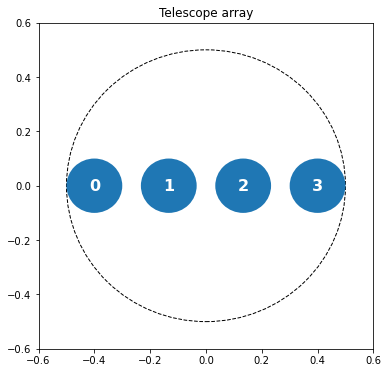

[-0.4, -0.13333333333333336, 0.1333333333333333, 0.4]


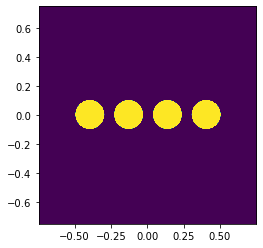

In [25]:
# each Dish now has a Stage with each variable!

class Dish:
    def __init__(self, x=0.0, y=0.0, d=0.1, ampl=1.0):
        'Dish - a single element in a telescope array at position (x,y) with diameter d and electric field amplitud ampl'
        self.x = x
        self.y = y
        self.d = d
        self.ampl = ampl
        self.xsc = Stage()
        self.ysc = Stage()
        self.dsc = Stage()
        self.asc = Stage()
        
        def set_polar(self, r, theta):
            'set position of Dish with polar coordinates'
            self.x = r*np.cos(theta)
            self.y = r*np.sin(theta)
            
        def get_polar(self):
            r = np.sqrt(self.x*self.x + self.y*self.y)
            theta = np.atan2(self.y, self.x)
            return (r, theta)
            

class TelArray:
    def __init__(self):
        self.dishes = []
        
    def show_array(self):
        fig, ax = plt.subplots(figsize=(6,6))
        ax.set_xlim(-0.6,0.6)
        ax.set_ylim(-0.6,0.6)
        c = plt.Circle((0.0, 0.0), 0.5, fc=None, fill=False, linestyle='--', color='black', zorder=-5)
        ax.add_artist(c)
        for i, (a) in enumerate(self.dishes):
            draw_circle = plt.Circle((a.x,a.y), a.d/2)
            ax.add_artist(draw_circle)
            ax.text(a.x, a.y, i, fontsize=16, color='white', weight='bold', horizontalalignment='center', verticalalignment='center')
            
            
        plt.title('Telescope array')
        plt.show()
            
    def add(self, Dish):
        'add a Dish to the Array'
        self.dishes.append(Dish)
        return len(self.dishes)
        
    def add_linear(self, n=5, length=1., diam=0.1, ampl=1.0):
        'a linear array of n Dishes with centre of first dish to last dish of length, diameter diam, transmission ampl'
        xpos = np.linspace(-length/2., length/2., n)
        for x in xpos:
            dish = Dish(x, 0., diam, ampl)
            self.add(dish)
            
        return len(self.dishes)
    
    def add_middle(self, n=5, diam=0.1, ampl=1.0):
        'add n Dishes at the origin diameter diam, transmission ampl'
        for x in xpos:
            dish = Dish(0, 0., diam, ampl)
            self.add(dish)
            
        return len(self.dishes)
    
    def make_grid(self):
        'returns a HCIpy Grid containing all the dishes in TelArray'
        # this seems very daft - surely there's a pythonic way of getting a quantity of a list of Objects?
        xd = []
        yd = []
        diam = []
        ampl = []
        for dish in self.dishes:
            xd.append(dish.x)
            yd.append(dish.y)
            diam.append(dish.d)
            ampl.append(dish.ampl)
            
        print(xd)
        interf_array = UnstructuredCoords((xd,yd))

        grid = Grid(interf_array)

        # currently we keep all dishes the same diameter - the first Diah
        dish = circular_aperture(diam[0]) # this is a Field generator

        interferom = make_segmented_aperture(dish, grid, np.array(ampl))
        
        return interferom
    
    
    
    def longest_time(self):
        '''calculates the longest time of all the Stages listed in the TelArray'''
        longest_time = 0.
        
        # loop over all the Dishes in the TelArray
        for di in self.dishes:    
            # loop through the Stages in the Dish object
            for st in (di.xsc, di.ysc, di.dsc, di.asc):
                # find longest time of all the Stages
                if (st.total_time() > longest_time):
                    longest_time = st.total_time()

        return longest_time

    
    def t(self, t):
        'given a TelArray, makes an HCIpy Grid at SINGLE time t'
        print(0)
        # WARNING: should barf if number of Dishes is not the same as 4* number of Scenes in the Play    
    
        xd = []
        yd = []
        diam = []
        ampl = []
        for dish in self.dishes:
            xd.append(dish.xsc.t(t))
            yd.append(dish.ysc.t(t))
            diam.append(dish.dsc.t(t))
            ampl.append(dish.asc.t(t))
            
        print(xd)
        interf_array = UnstructuredCoords((xd,yd))

        grid = Grid(interf_array)

        # currently we keep all dishes the same diameter - the first Diah
        dish = circular_aperture(diam[0]) # this is a Field generator

        interferom = make_segmented_aperture(dish, grid, np.array(ampl))
        
        return interferom
    
    def tidyup(self):
        # loop through all Scenes in your Dishes in your TelArray, bring them up to the latest time value
        return 0
        
    def tidyup(self):
        '''adds constant value Acts to brings up all the other Stages to the longest time'''

#        print('longest time is {}'.format(self.longest_time()))
        longest_time = self.longest_time()
    
        # loop through all the Dishes
        for di in self.dishes:
            # loop over all the Stages in each Dish object
            for s in (di.xsc, di.ysc, di.dsc, di.asc):
                stage_time = s.total_time()
                if (stage_time < longest_time):
#                print("adding a time delta to this one")
                    dt = longest_time - stage_time
                    last_value = s.t(stage_time)
                    s.add(Act(last_value,last_value,dt))

    
    # you can now build up your animation by adding TelArray[0].xsc.Add(asdf)
    # and then run tidyup on your Telarray

arr = TelArray()

print(arr.add_linear(4,1-0.2,0.2))
arr.show_array()
        
# start with two dishes

interfer = arr.make_grid()

pupil_grid = make_pupil_grid(1024,1.5)
inter_pupil = evaluate_supersampled(interfer, pupil_grid, 8)

imshow_field(inter_pupil)



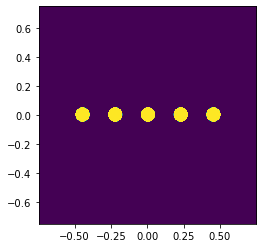

In [6]:
ndish = 5

ddish = .1

dish_x = np.linspace(-0.5+(ddish/2.), 0.5-(ddish/2.), ndish)

dish_y = np.zeros_like(dish_x)

interf_array = UnstructuredCoords((dish_x,dish_y))

grid = Grid(interf_array)

dish = circular_aperture(ddish) # this is a Field generator

interferom = make_segmented_aperture(dish, grid, np.array([1.0]))

pupil_grid = make_pupil_grid(1024,1.5)
inter_pupil = evaluate_supersampled(interferom, pupil_grid, 8)

imshow_field(inter_pupil)

In [ ]:
focal_grid = make_focal_grid(8, 14)

prop = FraunhoferPropagator(inter_pupil, focal_grid)

wf = Wavefront(inter_pupil)
focal_image = prop(wf).intensity
imshow_field(np.log10(focal_image / focal_image.max()), vmin=-5, cmap='inferno')

## HCIpy setup

In [ ]:
ddish = Stage()
ddish.add(Act(1.0, 0.05, 5,  'sig',10))
ddish.add(Act(0.05, 0.1, 5,  'sig',10))
ddish.add(Act(0.1, 0.2, 5,  'sig',10))

print(ddish.total_time())

t = np.arange(0,ddish.total_time(),0.05)

plt.plot(t, ddish.t(t))

In [ ]:
total_time_animation = ddish.total_time() # seconds
frame_rate = 10          # frames per second
total_frames = total_time_animation * frame_rate # seconds
supersampling = 4

plt.figure(figsize=(8,4))

anim = FFMpegWriter('interferometers_{}.mp4'.format(anim_version), framerate=frame_rate)

times = np.arange(0,total_time_animation, 1./frame_rate)

dd = ddish.t(times)

ndish = 5
pupil_grid = make_pupil_grid(1024,1.5)
focal_grid = make_focal_grid(8, 14)

for t in progressbar(range(np.int(total_frames))):

    dish = circular_aperture(dd[t]) # this is a Field generator

    dish_x = np.linspace(-0.5+(dd[t]/2.), 0.5-(dd[t]/2.), ndish)

    dish_y = np.zeros_like(dish_x)

    interf_array = UnstructuredCoords((dish_x,dish_y))

    grid = Grid(interf_array)
    
    interferom = make_segmented_aperture(dish, grid, np.array([1.0]))

    inter_pupil = evaluate_supersampled(interferom, pupil_grid, supersampling)

    plt.clf()
#    plt.suptitle('Timestep %d / %d' % (t, total_frames))
    
    plt.subplot(1,2,1)
    imshow_field(inter_pupil, cmap='gray')
    plt.title('Aperture')
    
    plt.text(0.05,0.05,anim_version, fontsize=12, color='white',
            horizontalalignment='left', verticalalignment='bottom',
            transform=plt.gca().transAxes)
    
    prop = FraunhoferPropagator(inter_pupil, focal_grid)

    wf = Wavefront(inter_pupil)
    focal_image = prop(wf).intensity
    
    plt.subplot(1,2,2)
    imshow_field(np.log10(focal_image / focal_image.max()), vmin=-5, cmap='inferno')
    #plt.title('frame {} at time {:.2f}'.format(timestep, timestep/frame_rate))
    plt.title('PSF')

    plt.text(0.95,0.05,"@mattkenworthy", fontsize=12, color='white',
        horizontalalignment='right', verticalalignment='bottom',
        transform=plt.gca().transAxes)
    
    anim.add_frame()

plt.close()
anim.close()

# Show created animation
anim

In [ ]:
!ffmpeg -i interferometers_v1.mp4 -vf "fps=10,scale=400:-1:flags=lanczos" -c:v pam -f image2pipe - | convert -delay 10 - -loop 0 -layers optimize interferometers_v1.gif